/var/folders/3p/99pv6lw14317n6rg5nx1xlf80000gn/T/ipykernel_63776/3975834519.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=n_periods, freq='M')


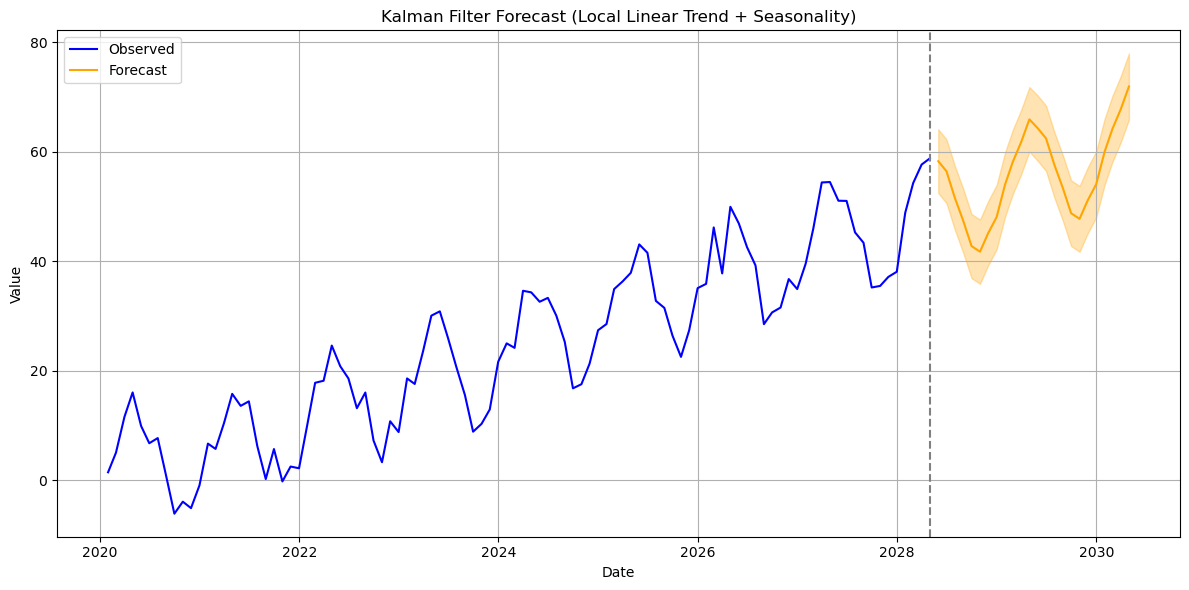

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Step 1: Generate synthetic time series data
np.random.seed(42)
n_periods = 100
trend = 0.5 * np.arange(n_periods)                  # Linear trend
seasonality = 10 * np.sin(2 * np.pi * np.arange(n_periods) / 12)  # Yearly seasonality (monthly data)
noise = np.random.normal(0, 3, size=n_periods)      # Gaussian noise

data = trend + seasonality + noise
dates = pd.date_range(start='2020-01-01', periods=n_periods, freq='M')
ts = pd.Series(data, index=dates)

# Step 2: Define the state space model
model = UnobservedComponents(ts, level='local linear trend', seasonal=12)

# Step 3: Fit the model
result = model.fit(disp=False)

# Step 4: Forecast future values
n_forecast = 24
forecast = result.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 5: Plot original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', color='blue')
plt.plot(forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3)
plt.axvline(ts.index[-1], color='gray', linestyle='--')
plt.title('Kalman Filter Forecast (Local Linear Trend + Seasonality)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2021-12-01 00:00:00


/Users/cameronaldren/miniconda3/envs/RL/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


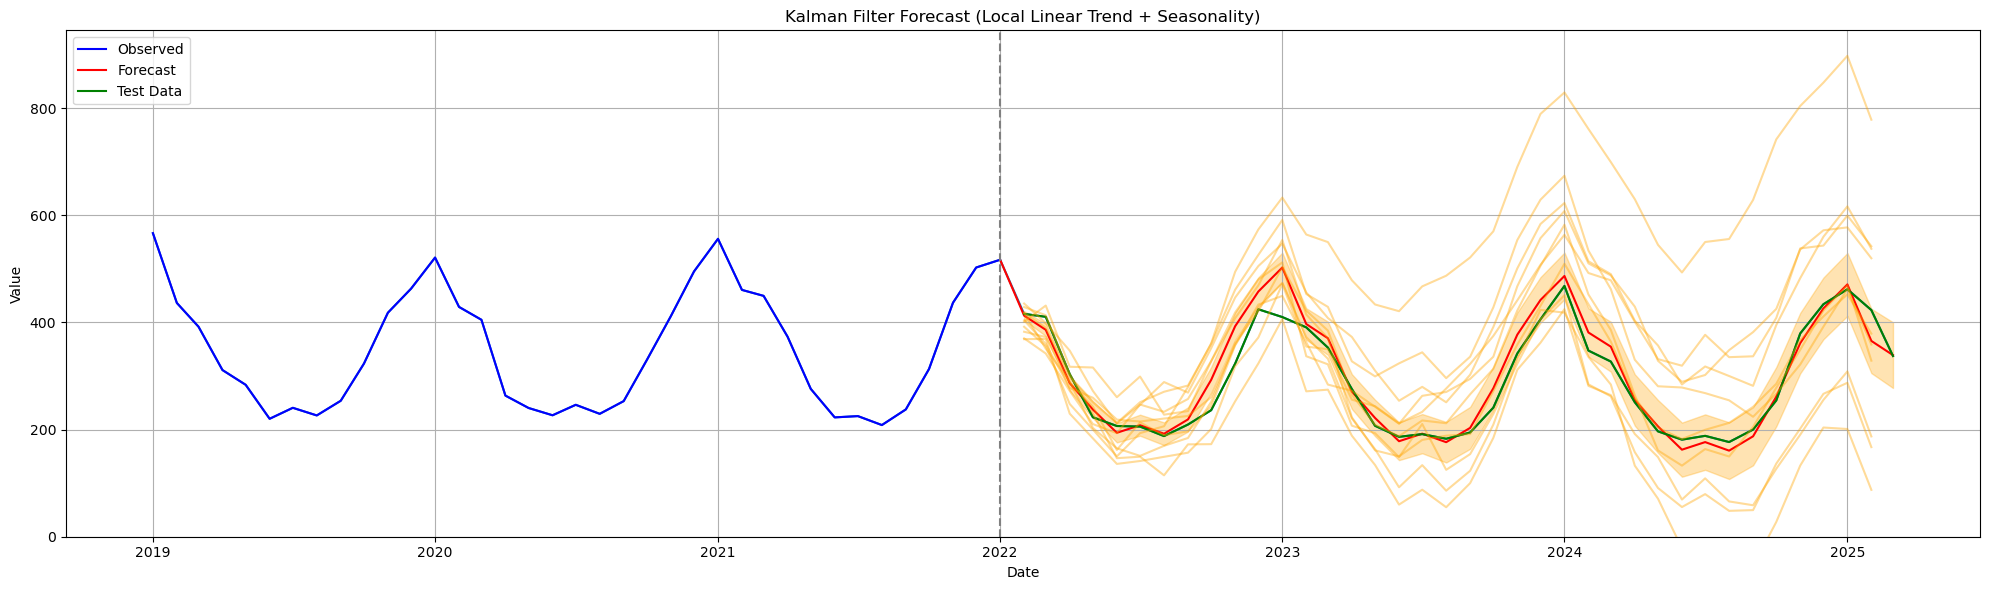

In [50]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from pathlib import Path 
import h2_gym


# Step 1: Generate synthetic time series data
path = Path(h2_gym.__file__).parent / "data/shipping/demand/src/data/analyzed/monthly_demand_clean.csv"
data = pd.read_csv(path)
data = data[(data['country'] == 'EU') & (data['type'] == 'total')]
#dates = pd.to_datetime(['01/' + str(month) + '/' + str(year) for month, year in zip(data['month'].values, data['year'].values)], dayfirst=True)  # Convert dates to datetime objects
_dates = pd.to_datetime(['01/' + str(month) + '/' + str(year) for month, year in zip(data['month'].values, data['year'].values)], dayfirst=True) # Convert dates to datetime objects
_data = data['demand'].values

# Split the data into train and test datasets
# Normalize the data


split_index = int(len(data) * 0.5)  # Use 60% of the data for training
train_data = _data[:split_index]
test_data = _data[split_index:]
train_dates = _dates[:split_index]
test_dates = _dates[split_index:]

# Use the training data for the time series
data = train_data
dates = train_dates

ts = pd.Series(data, index=dates)

# Step 2: Define the state space model
model = UnobservedComponents(ts, level='local linear trend', seasonal=12)

# Step 3: Fit the model
result = model.fit(disp=False)

# Step 4: Forecast future values
n_forecast = len(test_data)
forecast = result.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.75)
forecast_mean = pd.concat([pd.Series([ts.iloc[-1]], index=[ts.index[-1]]), forecast_mean])

# Step 3: Get state estimate and covariance at final time point
last_state_mean = result.filtered_state[:, -1]
last_state_cov = result.filtered_state_cov[:, :, -1]

# Step 4: Sample initial state from posterior
print(train_dates[-2])
sim_index = test_dates
n_forecast = len(sim_index)
n_simulations = 10
simulated_paths = []

for i in range(n_simulations):
    # Sample state vector from posterior
    sampled_state = np.random.multivariate_normal(last_state_mean, last_state_cov)

    # Simulate future values using simulate()
    sim = result.simulate(nsimulations=n_forecast, initial_state=sampled_state)
    simulated_paths.append(sim)

#simulated = model.simulate(nsimulations = 10, anchor='start', params = result.params)
# Step 5: Plot original data and forecast
plt.figure(figsize=(20, 6))
plt.plot(_dates,_data)
plt.plot(ts, label='Observed', color='blue')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(test_dates, test_data, label='Test Data', color='green')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3)
for sim in simulated_paths:
    plt.plot(sim_index[:-1], sim[1:], color='orange', alpha=0.4)
plt.axvline(ts.index[-1], color='gray', linestyle='--')
plt.title('Kalman Filter Forecast (Local Linear Trend + Seasonality)')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

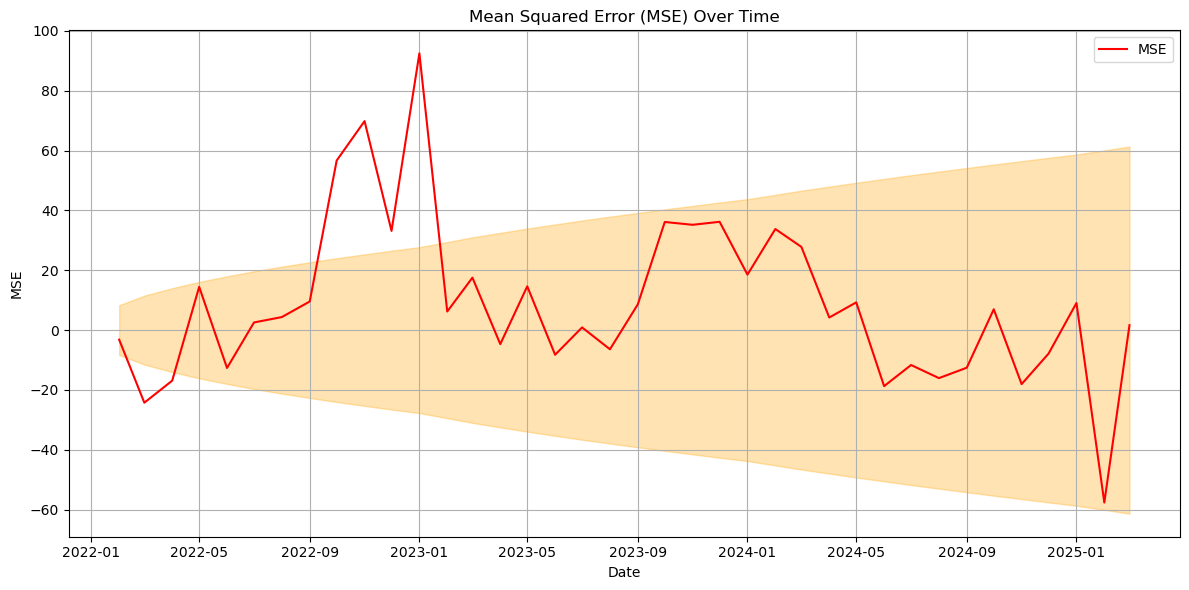

In [54]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for each time step
mse_values = (forecast_mean[1:] - test_data) 

# Plot MSE over time
plt.figure(figsize=(12, 6))
plt.plot(test_dates, mse_values, label='MSE', color='red')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Date')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Extract the measurement error (variance of the observation noise) from the Kalman filter
measurement_error_variance = result.filter_results.obs_cov.diagonal()

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0] - forecast_mean[1:],
                 forecast_ci.iloc[:, 1] - forecast_mean[1:],
                 color='orange', alpha=0.3)

/var/folders/3p/99pv6lw14317n6rg5nx1xlf80000gn/T/ipykernel_89943/3843492496.py:20: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dates = pd.to_datetime(data['date'].values, dayfirst=True)  # Convert dates to datetime objects
/Users/cameronaldren/miniconda3/envs/RL/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DatetimeIndex(['2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04',
               '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-08',
               '2025-02-09', '2025-02-10',
               ...
               '2026-01-22', '2026-01-23', '2026-01-24', '2026-01-25',
               '2026-01-26', '2026-01-27', '2026-01-28', '2026-01-29',
               '2026-01-30', '2026-01-31'],
              dtype='datetime64[ns]', length=365, freq='D')


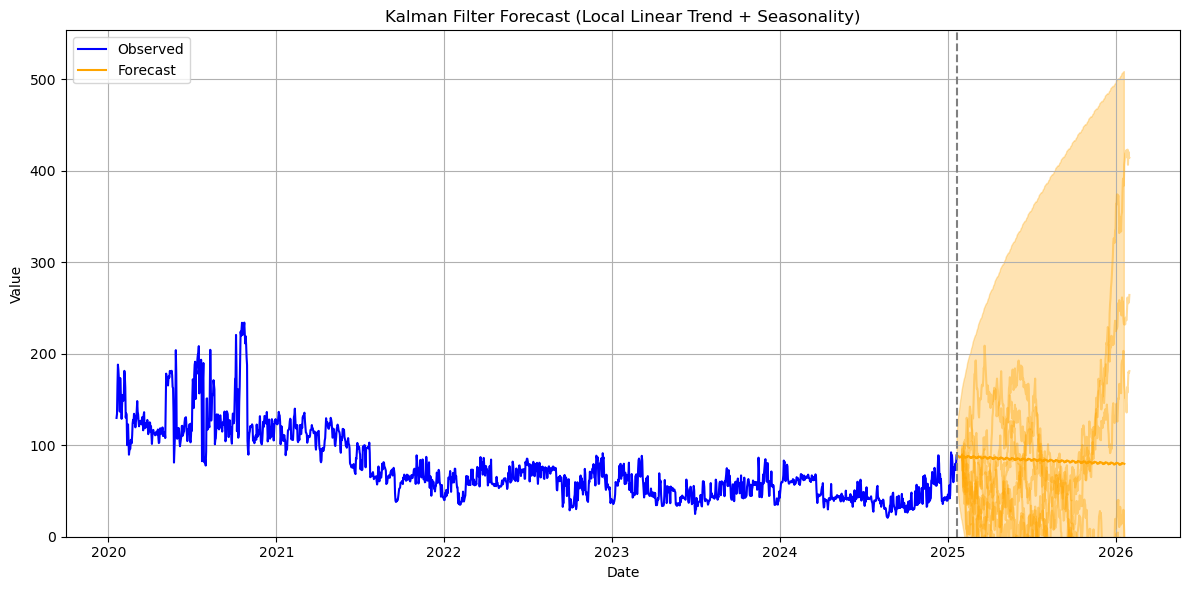

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from pathlib import Path 
import h2_gym


# Step 1: Generate synthetic time series data
np.random.seed(42)
n_periods = 100
trend = 0.5 * np.arange(n_periods)                  # Linear trend
seasonality = 10 * np.sin(2 * np.pi * np.arange(n_periods) / 12)  # Yearly seasonality (monthly data)
noise = np.random.normal(0, 3, size=n_periods)      # Gaussian noise

path = Path(h2_gym.__file__).parent / "data/shipping/demand/src/data/analyzed/daily_demand_clean.csv"
data = pd.read_csv(path)
data = data[(data['country'] == 'UK') & (data['type'] == 'industry')]
#dates = pd.to_datetime(['01/' + str(month) + '/' + str(year) for month, year in zip(data['month'].values, data['year'].values)], dayfirst=True)  # Convert dates to datetime objects
dates = pd.to_datetime(data['date'].values, dayfirst=True)  # Convert dates to datetime objects
data = data['demand'].values /10e11

ts = pd.Series(data, index=dates)

# Step 2: Define the state space model
model = UnobservedComponents(ts, level='local linear trend', seasonal=12)

# Step 3: Fit the model
result = model.fit(disp=False)

# Step 4: Forecast future values
n_forecast = 365
forecast = result.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_mean = pd.concat([pd.Series([ts.iloc[-1]], index=[ts.index[-1]]), forecast_mean])

# Step 3: Get state estimate and covariance at final time point
last_state_mean = result.filtered_state[:, -1]
last_state_cov = result.filtered_state_cov[:, :, -1]

# Step 4: Sample initial state from posterior
n_simulations = 10
sim_index = pd.date_range(ts.index[-3] + pd.offsets.MonthBegin(), periods=n_forecast, freq='d')
print(sim_index)
simulated_paths = []

for i in range(n_simulations):
    # Sample state vector from posterior
    sampled_state = np.random.multivariate_normal(last_state_mean, last_state_cov)

    # Simulate future values using simulate()
    sim = result.simulate(nsimulations=n_forecast, initial_state=sampled_state)
    simulated_paths.append(sim)

#simulated = model.simulate(nsimulations = 10, anchor='start', params = result.params)
# Step 5: Plot original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', color='blue')
plt.plot(forecast_mean, label='Forecast', color='orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3)
for sim in simulated_paths:
    plt.plot(sim_index, sim, color='orange', alpha=0.4)
plt.axvline(ts.index[-1], color='gray', linestyle='--')
plt.title('Kalman Filter Forecast (Local Linear Trend + Seasonality)')
plt.xlabel('Date')
plt.ylim(bottom=0)
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
model_parameters = {
    "batch_size": 128,              # How many sequences per training batch
    "learning_rate": 5e-4,          # Learning rate for optimizers
    "noise_dim": 32,                # Dimensionality of random noise input (for generator)
    "dim": 24,                      # Hidden units in RNN layers (embedder, generator, etc.)
    "hidden_dim": 24,               # Can also define this separately from 'dim'
    "num_layers": 3,                # RNN depth — usually 2–3 layers
    "iterations": 5000,            # Total training steps (adjust for convergence)
    "seq_len": 24                  # Length of each time series sequence
}

from ydata.synthesizers import TimeSeriesSynthesizer
from ydata.synthesizers import ModelParameters, TrainParameters

model_args = ModelParameters(batch_size=100,
                             lr=0.001,
                             betas=(0.2, 0.9),
                             latent_dim=20,
                             gp_lambda=2,
                             pac=1)

train_args = TrainParameters(epochs=400,
                             sequence_length=56,
                             sample_length=8,
                             rounds=1,
                             measurement_cols=['demand'])

synth = TimeSeriesSynthesizer(model_parameters)
synth.train(train_data, train_steps=500)
synthetic_data = synth.sample(n_samples=100)

# Training the DoppelGANger synthesizer
model_dop_gan = TimeSeriesSynthesizer(modelname='doppelganger',model_parameters=model_args)
model_dop_gan.fit(train_data, train_args, num_cols=['demand'])


ImportError: cannot import name 'Scalar' from 'dask.dataframe.core' (/Users/cameronaldren/miniconda3/envs/RL/lib/python3.10/site-packages/dask/dataframe/core.py)

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

train_data = pd.Series(train_data, index=train_dates)
test_data = pd.Series(test_data, index=test_dates)

# 1. Simple Moving Average Forecast (last window)
def sma_forecast(train, test, window):
    history = train[-window:]
    forecast = []
    for _ in test:
        pred = np.mean(history)
        forecast.append(pred)
        history = np.append(history[1:], pred)
    return forecast

# 2. Single Exponential Smoothing
def ses_forecast(train, test, alpha):
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    forecast = model.forecast(len(test))
    return forecast

# 3. Linear Exponential Smoothing (Holt)
def les_forecast(train, test, alpha, beta):
    model = Holt(train).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
    forecast = model.forecast(len(test))
    return forecast

# 4. Seasonal Exponential Smoothing (Holt-Winters)
def seasonal_forecast(train, test, season_length, alpha, beta, gamma):
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=season_length)
    model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, optimized=False)
    forecast = model_fit.forecast(len(test))
    return forecast

# Forecasts
sma_pred = sma_forecast(train_data, test_data, window=5)
ses_pred = ses_forecast(train_data, test_data, alpha=0.2)
les_pred = les_forecast(train_data, test_data, alpha=0.2, beta=0.1)
seasonal_pred = seasonal_forecast(train_data, test_data, season_length=12, alpha=0.2, beta=0.1, gamma=0.3)

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(train_data, label='Train', color='black')
plt.plot(test_data.index, test_data.values, label='Test', color='gray')

plt.plot(test_data.index, sma_pred, label='SMA Forecast', linestyle='--')
plt.plot(test_data.index, ses_pred, label='SES Forecast', linestyle='--')
plt.plot(test_data.index, les_pred, label='Linear Exp Smoothing Forecast', linestyle='--')
plt.plot(test_data.index, seasonal_pred, label='Seasonal Exp Smoothing Forecast', linestyle='--')
plt.ylim(0, 120)

plt.title('Time Series Forecasts Using Different Smoothing Methods')
plt.legend()
plt.grid(True)
plt.show()

/Users/cameronaldren/miniconda3/envs/RL/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cameronaldren/miniconda3/envs/RL/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cameronaldren/miniconda3/envs/RL/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.